## Libraries

In [1]:
import sys
sys.path.append('./venv/lib/python3.6/site-packages')

In [2]:
import os
import time
import random

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

In [3]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms as vtransforms
from torchvision import utils as vutils
from torchvision import datasets

In [4]:
from gans.utils.data import CartoonSet
from gans.utils.layers import *
from gans.utils.functions import *
from gans.models import *
from gans.trainer import *

## Random seed

In [5]:
# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Inputs

In [6]:
# Dataset
data_root = './datasets'

# data_name = 'FashionMNIST'
# data_name = 'MNIST'

# batch_size = 200
# sample_size = 50
# nrow = 5

data_name = 'CartoonSet'

batch_size = 128
sample_size = 32
nrow = 4

num_epochs = 100

num_workers = 8


# Output dir
output_root = './output/vanillaGAN'
# overwrite real sample output
overwrite_real = False

noize_dim = 100

# Optimization parameters
lr = 0.001
beta1 = 0.5

## Device

In [7]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print('using device: ', device)

using device:  cuda:1


## Dataset

In [8]:
img_size = 28
in_channels = 1

if data_name == 'CartoonSet':
    img_size = 75
    dataset = CartoonSet(root=os.path.join(data_root, data_name), 
                         transform=vtransforms.Compose([
                             vtransforms.CenterCrop(size=400),
                             vtransforms.Resize(size=img_size), 
                             vtransforms.ToTensor(),
                             vtransforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                         ]))
    
elif data_name == 'MNIST':
    dataset = datasets.MNIST(root=os.path.join(data_root, data_name), 
                             download=True,
                             transform=vtransforms.Compose([
                                 vtransforms.ToTensor(),
                                 vtransforms.Normalize((0.5,), (0.5,)),
                         ]))
elif data_name == 'FashionMNIST':
    dataset = datasets.FashionMNIST(root=os.path.join(data_root, data_name), 
                                    download=True,
                                    transform=vtransforms.Compose([
                                        vtransforms.ToTensor(),
                                        vtransforms.Normalize((0.5,), (0.5,)),
                                    ]))
    
dtype = dataset[0][0].dtype
img_shape = dataset[0][0].shape

## Dataloader

In [9]:
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         shuffle=True, 
                                         num_workers=num_workers)

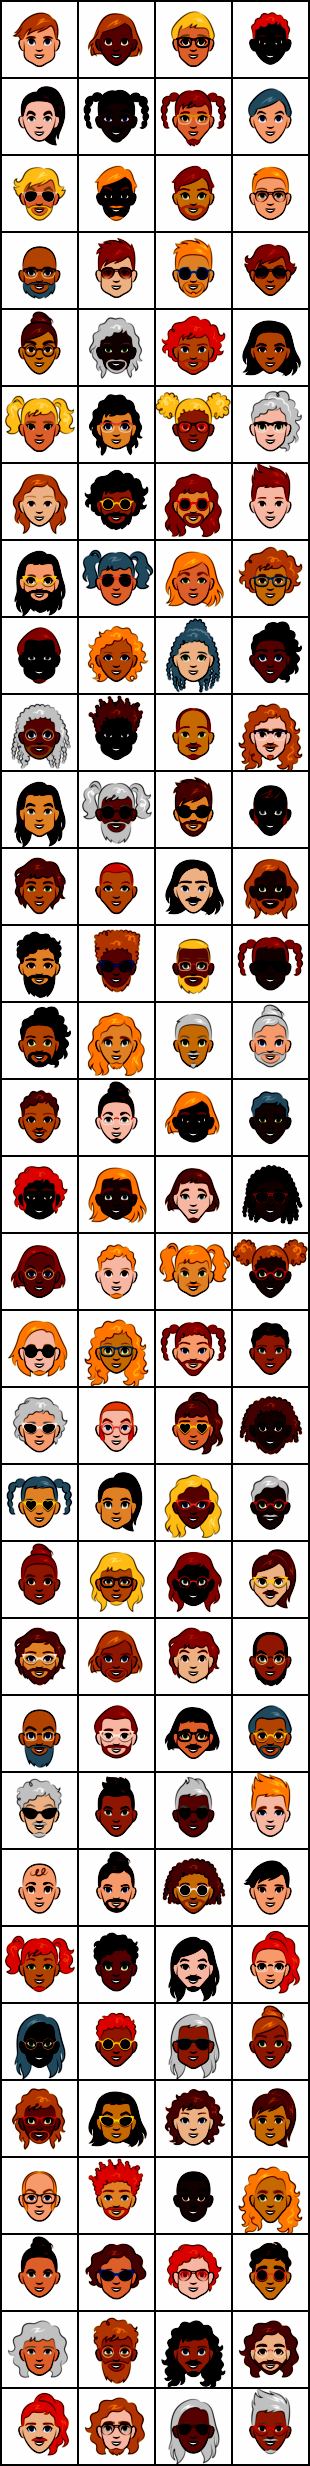

In [10]:
if not os.path.exists(os.path.join(output_root, data_name)):
    os.makedirs(os.path.join(output_root, data_name))

real_sample_path = os.path.join(output_root, data_name, 'real_samples.png')


real_batch = next(iter(dataloader))

vutils.save_image(real_batch[0], real_sample_path, 
                  normalize=True, range=(0,1), nrow=nrow)
Image(real_sample_path)

## Model

In [11]:
C, H, W = img_shape
features = C * H * W

In [12]:
layersG = [
    *linearBlock(noize_dim, 128, normalize=False, activation='ReLU'),
    *linearBlock(128, 256, activation='ReLU'),
    *linearBlock(256, 512, activation='ReLU'),
    *linearBlock(512, 1024, activation='ReLU'),
    *linearBlock(1024, features, normalize=False, activation='Tanh'),
]

netG = Generator(layers=layersG, img_shape=img_shape)
print(netG)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Linear(in_features=1024, out_features=16875, bias=True)
    (12): Tanh()
    (13): Unflatten2d(img_shape=(3, 75, 75))
  )
)


In [13]:
layersD = [
    *linearBlock(features, 1024, normalize=False, activation='LeakyReLU'),
    *linearBlock(1024, 512, normalize=False, activation='LeakyReLU'),
    *linearBlock(512, 256, normalize=False, activation='LeakyReLU'),
    *linearBlock(256, 128, normalize=False, activation='LeakyReLU'),
    *linearBlock(128, 1, normalize=False, activation='Sigmoid'),
]

netD = Discriminator(layers=layersD)
print(netD)

Discriminator(
  (model): Sequential(
    (0): Flatten()
    (1): Linear(in_features=16875, out_features=1024, bias=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): LeakyReLU(negative_slope=0.2, inplace)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): Linear(in_features=128, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


## Training

In [14]:
trainer = GANTrainer(generator=netG, discriminator=netD,
                     optimizer=optim.Adam, loss=nn.BCELoss(), 
                     device='cuda:1', multi_gpu=False, output_path=os.path.join(output_root, data_name),
                     batch_size=batch_size, num_epochs=num_epochs, sample_size=sample_size)

In [15]:
trainer.train(dataloader=dataloader, nrow=nrow)

/home/shu/.local/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[Epoch 0/100][Batch 0/79] Loss_D: 1.39 Loss_G: 0.85
[Epoch 0/100][Batch 15/79] Loss_D: 0.30 Loss_G: 3.94
[Epoch 0/100][Batch 30/79] Loss_D: 0.34 Loss_G: 5.94
[Epoch 0/100][Batch 45/79] Loss_D: 1.89 Loss_G: 0.61
[Epoch 0/100][Batch 60/79] Loss_D: 0.80 Loss_G: 1.95
[Epoch 0/100][Batch 75/79] Loss_D: 0.58 Loss_G: 2.68
Epoch 0 running time: 6.96


/home/shu/.local/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[Epoch 1/100][Batch 0/79] Loss_D: 0.91 Loss_G: 0.69
[Epoch 1/100][Batch 15/79] Loss_D: 0.88 Loss_G: 1.15
[Epoch 1/100][Batch 30/79] Loss_D: 1.18 Loss_G: 0.56
[Epoch 1/100][Batch 45/79] Loss_D: 1.15 Loss_G: 0.84
[Epoch 1/100][Batch 60/79] Loss_D: 1.35 Loss_G: 0.27
[Epoch 1/100][Batch 75/79] Loss_D: 1.09 Loss_G: 1.01
Epoch 1 running time: 7.07
[Epoch 2/100][Batch 0/79] Loss_D: 1.07 Loss_G: 0.89
[Epoch 2/100][Batch 15/79] Loss_D: 1.22 Loss_G: 1.13
[Epoch 2/100][Batch 30/79] Loss_D: 1.30 Loss_G: 0.85
[Epoch 2/100][Batch 45/79] Loss_D: 1.18 Loss_G: 0.89
[Epoch 2/100][Batch 60/79] Loss_D: 1.32 Loss_G: 1.18
[Epoch 2/100][Batch 75/79] Loss_D: 2.91 Loss_G: 0.47
Epoch 2 running time: 6.80
[Epoch 3/100][Batch 0/79] Loss_D: 1.24 Loss_G: 0.78
[Epoch 3/100][Batch 15/79] Loss_D: 3.68 Loss_G: 0.64
[Epoch 3/100][Batch 30/79] Loss_D: 1.30 Loss_G: 0.59
[Epoch 3/100][Batch 45/79] Loss_D: 1.41 Loss_G: 0.64
[Epoch 3/100][Batch 60/79] Loss_D: 1.18 Loss_G: 0.94
[Epoch 3/100][Batch 75/79] Loss_D: 0.88 Loss_G: 

[Epoch 24/100][Batch 60/79] Loss_D: 1.46 Loss_G: 0.66
[Epoch 24/100][Batch 75/79] Loss_D: 1.28 Loss_G: 0.75
Epoch 24 running time: 6.80
[Epoch 25/100][Batch 0/79] Loss_D: 1.28 Loss_G: 0.73
[Epoch 25/100][Batch 15/79] Loss_D: 1.29 Loss_G: 0.80
[Epoch 25/100][Batch 30/79] Loss_D: 1.30 Loss_G: 1.00
[Epoch 25/100][Batch 45/79] Loss_D: 1.23 Loss_G: 0.77
[Epoch 25/100][Batch 60/79] Loss_D: 1.27 Loss_G: 0.71
[Epoch 25/100][Batch 75/79] Loss_D: 1.24 Loss_G: 0.89
Epoch 25 running time: 6.98
[Epoch 26/100][Batch 0/79] Loss_D: 1.38 Loss_G: 1.08
[Epoch 26/100][Batch 15/79] Loss_D: 1.30 Loss_G: 0.83
[Epoch 26/100][Batch 30/79] Loss_D: 1.24 Loss_G: 1.12
[Epoch 26/100][Batch 45/79] Loss_D: 1.20 Loss_G: 1.74
[Epoch 26/100][Batch 60/79] Loss_D: 1.31 Loss_G: 0.72
[Epoch 26/100][Batch 75/79] Loss_D: 1.26 Loss_G: 0.80
Epoch 26 running time: 6.94
[Epoch 27/100][Batch 0/79] Loss_D: 1.30 Loss_G: 1.04
[Epoch 27/100][Batch 15/79] Loss_D: 1.44 Loss_G: 0.54
[Epoch 27/100][Batch 30/79] Loss_D: 1.41 Loss_G: 5.34
[

[Epoch 48/100][Batch 0/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 48/100][Batch 15/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 48/100][Batch 30/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 48/100][Batch 45/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 48/100][Batch 60/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 48/100][Batch 75/79] Loss_D: 27.63 Loss_G: 0.00
Epoch 48 running time: 7.33
[Epoch 49/100][Batch 0/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 49/100][Batch 15/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 49/100][Batch 30/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 49/100][Batch 45/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 49/100][Batch 60/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 49/100][Batch 75/79] Loss_D: 27.63 Loss_G: 0.00
Epoch 49 running time: 6.72
[Epoch 50/100][Batch 0/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 50/100][Batch 15/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 50/100][Batch 30/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 50/100][Batch 45/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 50/100][Batch 60/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 50/10

[Epoch 71/100][Batch 0/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 71/100][Batch 15/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 71/100][Batch 30/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 71/100][Batch 45/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 71/100][Batch 60/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 71/100][Batch 75/79] Loss_D: 27.63 Loss_G: 0.00
Epoch 71 running time: 6.91
[Epoch 72/100][Batch 0/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 72/100][Batch 15/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 72/100][Batch 30/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 72/100][Batch 45/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 72/100][Batch 60/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 72/100][Batch 75/79] Loss_D: 27.63 Loss_G: 0.00
Epoch 72 running time: 6.60
[Epoch 73/100][Batch 0/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 73/100][Batch 15/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 73/100][Batch 30/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 73/100][Batch 45/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 73/100][Batch 60/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 73/10

[Epoch 94/100][Batch 0/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 94/100][Batch 15/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 94/100][Batch 30/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 94/100][Batch 45/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 94/100][Batch 60/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 94/100][Batch 75/79] Loss_D: 27.63 Loss_G: 0.00
Epoch 94 running time: 6.54
[Epoch 95/100][Batch 0/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 95/100][Batch 15/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 95/100][Batch 30/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 95/100][Batch 45/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 95/100][Batch 60/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 95/100][Batch 75/79] Loss_D: 27.63 Loss_G: 0.00
Epoch 95 running time: 7.28
[Epoch 96/100][Batch 0/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 96/100][Batch 15/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 96/100][Batch 30/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 96/100][Batch 45/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 96/100][Batch 60/79] Loss_D: 27.63 Loss_G: 0.00
[Epoch 96/10

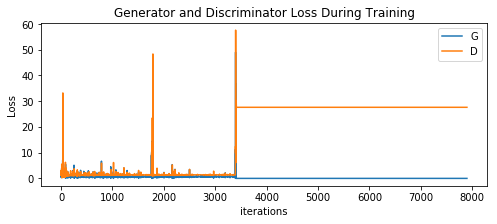

In [16]:
plt.figure(figsize=(8,3))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trainer.g_losses,label="G")
plt.plot(trainer.d_losses,label="D")

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(output_root, data_name, 'g_d_loss.png'))
plt.show()

In [17]:
gif_generator(image_dir=os.path.join(output_root, data_name), 
              name_pattern=r'fake_samples_epoch_[\d]+|.png')